retrieving "D:\projects\car-license-plate-recognition\doc\problem\placas\141002\Pa140028.jpg.pkz"


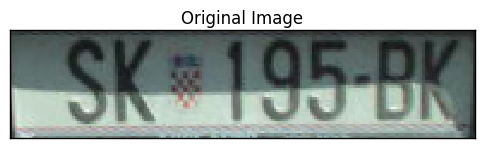

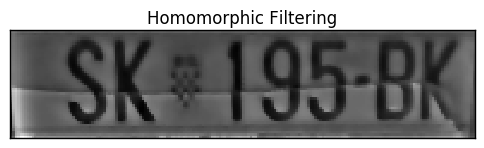

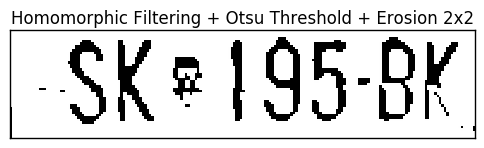

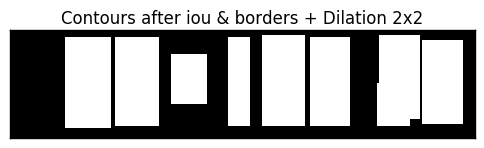

In [8]:
% matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
from plate import detect, segment, noise, roi, binarization
import numpy as np
import iou

# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140022.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140015.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140028.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040022.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plate points retrieving
points = []
points_path = img_path + '.pkz'
if os.path.exists(points_path):
    points = roi.retrieve(points_path, decompress=False)
else:
    print(img_path, ' points file for plate not found')
    exit(1)

# plate segmentation
plates = segment.segment_plates(img, [points])
gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)
h, w = gray.shape

# bilateral filter
wsize = h>>3
gray = cv2.bilateralFilter(gray, wsize, 30, wsize)

# noise filtering
filtered = noise.homomorphic(gray, 0.1, 1.)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(plates[0], interpolation='none')
plt.show()

plt.title('Homomorphic Filtering'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered, cmap='gray', interpolation='none')
plt.show()

# binarization
_, filtered_bin = cv2.threshold(filtered, 0, 255, cv2.THRESH_OTSU)
img_bin = cv2.dilate(filtered_bin, cv2.getStructuringElement(cv2.MORPH_ERODE, (2, 2)), iterations=1)
# img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4)))

plt.title('Homomorphic Filtering + Otsu Threshold + Erosion 2x2'), plt.xticks([]), plt.yticks([])
plt.imshow(img_bin, cmap='gray', interpolation='none')
plt.show()

# clean contours with iou
image, contours, hierarchy = cv2.findContours(img_bin, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
bin_cnt = np.zeros(img_bin.shape, np.uint8)
maxrect = [0, 0, w, h]
border_radius = 5
for i, cnt in enumerate(contours):
    rx, ry, rw, rh = cv2.boundingRect(cnt)
    rxf = rx + rw - 1
    ryf = ry + rh - 1
    iou_ratio = iou.bb_intersection_over_union(maxrect, [rx, ry, rxf, ryf])
    has_right_size = iou_ratio > 0.005 and iou_ratio < 0.75
    close_to_border = rxf < border_radius or ryf < border_radius or rx + border_radius > w or ry + border_radius > h
    if has_right_size and not close_to_border:
        cv2.rectangle(bin_cnt, (rx, ry), (rxf, ryf), 255, -1)
#     cv2.drawContours(bin_cnt, contours, i, (255, 255, 255), cv2.FILLED, 8)
bin_cnt = cv2.dilate(bin_cnt, cv2.getStructuringElement(cv2.MORPH_ERODE, (2, 2)), iterations=1)

plt.title('Contours after iou & borders + Dilation 2x2'), plt.xticks([]), plt.yticks([])
plt.imshow(bin_cnt, cmap='gray', interpolation='none')
plt.show()